# PREPARE DATA

Load and concatenate dataframes from individual months

## Prepare

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
DROPNANS = True
INCIDENT = 'roubo_celular'

# TODO: inconsistencies found in temporal data
#BASE_COLS = ['DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA',]
# QUICKFIX: use first day of month as incident date
BASE_COLS = ['PERIDOOCORRENCIA']

# Neighborhood dataframe
COLS_HOOD = BASE_COLS + ['BAIRRO']

# Localizations dataframe
COLS_LOC = BASE_COLS + ['LATITUDE', 'LONGITUDE']

# Prints to check everything is ok
DEBUG_MODE = True

In [4]:
periods = [f'2023_{i:02d}' for i in range(1, 13)] + ['2024_01']
#periods = [f'2023_{i:02d}' for i in range(1, 2)] # + ['2024_01']
periods

['2023_01',
 '2023_02',
 '2023_03',
 '2023_04',
 '2023_05',
 '2023_06',
 '2023_07',
 '2023_08',
 '2023_09',
 '2023_10',
 '2023_11',
 '2023_12',
 '2024_01']

In [5]:
# just for reference
dfx = pd.read_excel(f"../data/{INCIDENT}/2024_01.xlsx")

In [6]:
dfx.columns

Index(['ANO_BO', 'NUM_BO', 'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO',
       'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA',
       'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE',
       'NUMERO_BOLETIM_PRINCIPAL', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE',
       'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'EXAME', 'SOLUCAO',
       'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA',
       'DESDOBRAMENTO', 'STATUS', 'TIPOPESSOA', 'VITIMAFATAL', 'NATURALIDADE',
       'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'ESTADOCIVIL',
       'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS', 'NATUREZAVINCULADA',
       'TIPOVINCULO', 'RELACIONAMENTO', 'PARENTESCO', 'PLACA_VEICULO',
       'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO',
       'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO', 'ANO_MODELO',
       'DESCR_TIPO_VEICULO', 'QUANT_CELULAR', 'MARCA_CELULAR'],
      dtype='object')

In [7]:
df_hood = None
df_loc = None
for period in periods:
    df = pd.read_excel(f"../data/{INCIDENT}/{period}.xlsx")
    # filter capital
    df = df[df["CIDADE"] == "S.PAULO"]

    # standarize neighborhood
    df["BAIRRO"] = df["BAIRRO"].str.upper()

    ## TODO: inconsistencies found in temporal data
    #df['DATAOCORRENCIA'] = pd.to_datetime(df['DATAOCORRENCIA'], format='%d/%m/%Y')
    #if DEBUG_MODE:
    #    print(
    #        f"{period}\t{df['DATAOCORRENCIA'].min()}\t{df['DATAOCORRENCIA'].max()}"
    #    )
    # QUICKFIX: use first day of month as incident date
    year, month = [int(s) for s in period.split(sep='_')]
    df["period"] = period
    df["year"] = year
    df["month"] = month
    df["date"] = pd.Timestamp(year=year, month=month, day=1)
    COLS_DT = ["period", "year", "month", "date"]

    df_hood = pd.concat([df_hood, df[COLS_HOOD + COLS_DT]])
    df_loc = pd.concat([df_loc, df[COLS_LOC + COLS_DT]])

    print(f"Period {period} done")

Period 2023_01 done
Period 2023_02 done
Period 2023_03 done
Period 2023_04 done
Period 2023_05 done
Period 2023_06 done
Period 2023_07 done
Period 2023_08 done
Period 2023_09 done
Period 2023_10 done
Period 2023_11 done
Period 2023_12 done
Period 2024_01 done


Remove NaNs,

In [8]:
df_hood["BAIRRO"].value_counts()

BAIRRO
REPUBLICA               2970
CAPAO REDONDO           2967
PINHEIROS               2445
ITAIM BIBI              2369
CAMPO LIMPO             2160
                        ... 
JARDIM COTIANA             1
VILA ARAPUA                1
JARDIM MORADA DO SOL       1
PARQUE SAO LUCAS           1
CIDADE DE DEUS             1
Name: count, Length: 1772, dtype: int64

In [9]:
print(df_hood.shape, df_loc.shape)
df_hood = df_hood[df_hood["BAIRRO"].notna()]
df_loc = df_loc[(df_loc["LONGITUDE"].notna())]
df_loc = df_loc[(df_loc["LATITUDE"].notna())]
print(df_hood.shape, df_loc.shape)

(136917, 6) (136917, 7)
(136158, 6) (121930, 7)


In [10]:
df_hood.groupby("date")["period"].count()

date
2023-01-01     5921
2023-02-01     9319
2023-03-01    13717
2023-04-01    11185
2023-05-01    11574
2023-06-01    10622
2023-07-01    10528
2023-08-01    11155
2023-09-01    10686
2023-10-01    10926
2023-11-01    10521
2023-12-01    10533
2024-01-01     9471
Name: period, dtype: int64

In [11]:
df_loc.groupby("date")["period"].count()

date
2023-01-01     5298
2023-02-01     8413
2023-03-01    12070
2023-04-01     9923
2023-05-01    10315
2023-06-01     9615
2023-07-01     9637
2023-08-01     9996
2023-09-01     9700
2023-10-01     9809
2023-11-01     9427
2023-12-01     9336
2024-01-01     8391
Name: period, dtype: int64

## Problem with `df_hood`: too much granularity

Municipio -> Prefeituras Regionais -> Distritos -> Bairros

In [12]:
df_hood["BAIRRO"].value_counts()

BAIRRO
REPUBLICA               2970
CAPAO REDONDO           2967
PINHEIROS               2445
ITAIM BIBI              2369
CAMPO LIMPO             2160
                        ... 
JARDIM COTIANA             1
VILA ARAPUA                1
JARDIM MORADA DO SOL       1
PARQUE SAO LUCAS           1
CIDADE DE DEUS             1
Name: count, Length: 1772, dtype: int64

Solutions:
- Map "BAIRRO" column to new "DISTRITO" column (hard).
- Use `df_loc` to intersect (lat, lon) with available district areas.

# Continue with `df_loc`

Fix types in location columns,

In [13]:
df_loc.dtypes

PERIDOOCORRENCIA            object
LATITUDE                    object
LONGITUDE                  float64
period                      object
year                         int64
month                        int64
date                datetime64[us]
dtype: object

In [14]:
df_loc["LATITUDE"].map(type).value_counts()

LATITUDE
<class 'float'>    102319
<class 'int'>       19610
<class 'str'>           1
Name: count, dtype: int64

safe way: keep only floats,

TODO: maybe include ints

In [15]:
print(df_loc.shape)
df_loc = df_loc[df_loc["LATITUDE"].map(type) == float]
print(df_loc.shape)

(121930, 7)
(102319, 7)


In [16]:
df_loc["LATITUDE"] = df_loc["LATITUDE"].astype(float)

In [17]:
df_loc[["LONGITUDE", "LATITUDE"]].describe()

,LONGITUDE,LATITUDE
count,1.023190e+05,1.023190e+05
mean,-1.917928e+14,-1.017803e+14
std,2.282972e+14,1.161833e+14
min,-4.682100e+14,-2.391136e+14
25%,-4.662777e+14,-2.355412e+14
50%,-4.669636e+10,-2.364833e+10
75%,-4.669047e+08,-2.360323e+08
max,-4.644300e+04,-2.359700e+04


the orders of magnitudes of entries are absolutely absurd! solution:

## HARDFIX

123456789012345 -> 12.345...

In [18]:
import numpy as np

In [19]:
def fixlatlon(n) -> float:
    tenpow = np.ceil(np.log10(np.abs(float(n)))) - 2
    return n / (10**tenpow)

In [20]:
#np.log10(float(12345678.901234567))

In [21]:
#fixlatlon(-12345678.901234567)

In [ ]:
df_loc["LATITUDE"] = df_loc["LATITUDE"].apply(fixlatlon)
df_loc["LONGITUDE"] = df_loc["LONGITUDE"].apply(fixlatlon)

In [56]:
df_loc[["LATITUDE", "LONGITUDE"]].describe()

,LATITUDE,LONGITUDE
count,102319.000000,102319.000000
mean,-23.577875,-46.624283
std,0.072770,0.107551
min,-23.938062,-46.855411
25%,-23.621361,-46.699740
50%,-23.565578,-46.644275
75%,-23.529952,-46.565603
max,-23.357000,-46.365850


Add geometry column,

In [24]:
df_loc["geometry"] = df_loc.apply(lambda x: Point(x["LONGITUDE"], x["LATITUDE"]), axis=1)

Create GeoDataFrame,

In [25]:
gdf_loc = gpd.GeoDataFrame(df_loc, geometry="geometry")

<Axes: >

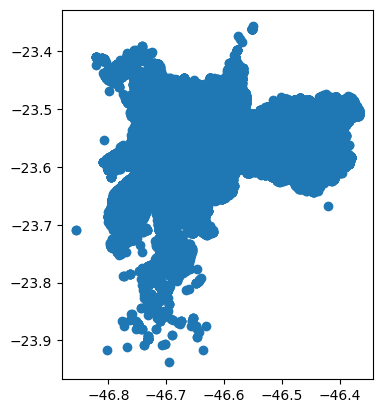

In [37]:
gdf_loc.plot()

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

Read Districts,

In [102]:
GEO_DATA_DIR = "../data/malhas"
PATH_DISTRICT = f"{GEO_DATA_DIR}/SIRGAS_GPKG_distrito.gpkg"
PATH_DENSITY = f"{GEO_DATA_DIR}/SIRGAS_GPKG_densidadedemografica.gpkg"
PATH_HIDRO = f"{GEO_DATA_DIR}/SIRGAS_SHP_hidromassadagua_polygon.shp"

In [66]:
gdf_distr = gpd.read_file(PATH_DISTRICT)

In [67]:
layers = gpd.list_layers(PATH_DISTRICT)
print(layers)

                   name geometry_type
0  SIRGAS_GPKG_distrito       Unknown


In [68]:
gdf_distr.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [71]:
#gdf_distr.set_crs(epsg=4674)
gdf_distr = gdf_distr.to_crs(crs="EPSG:4674")

<Axes: >

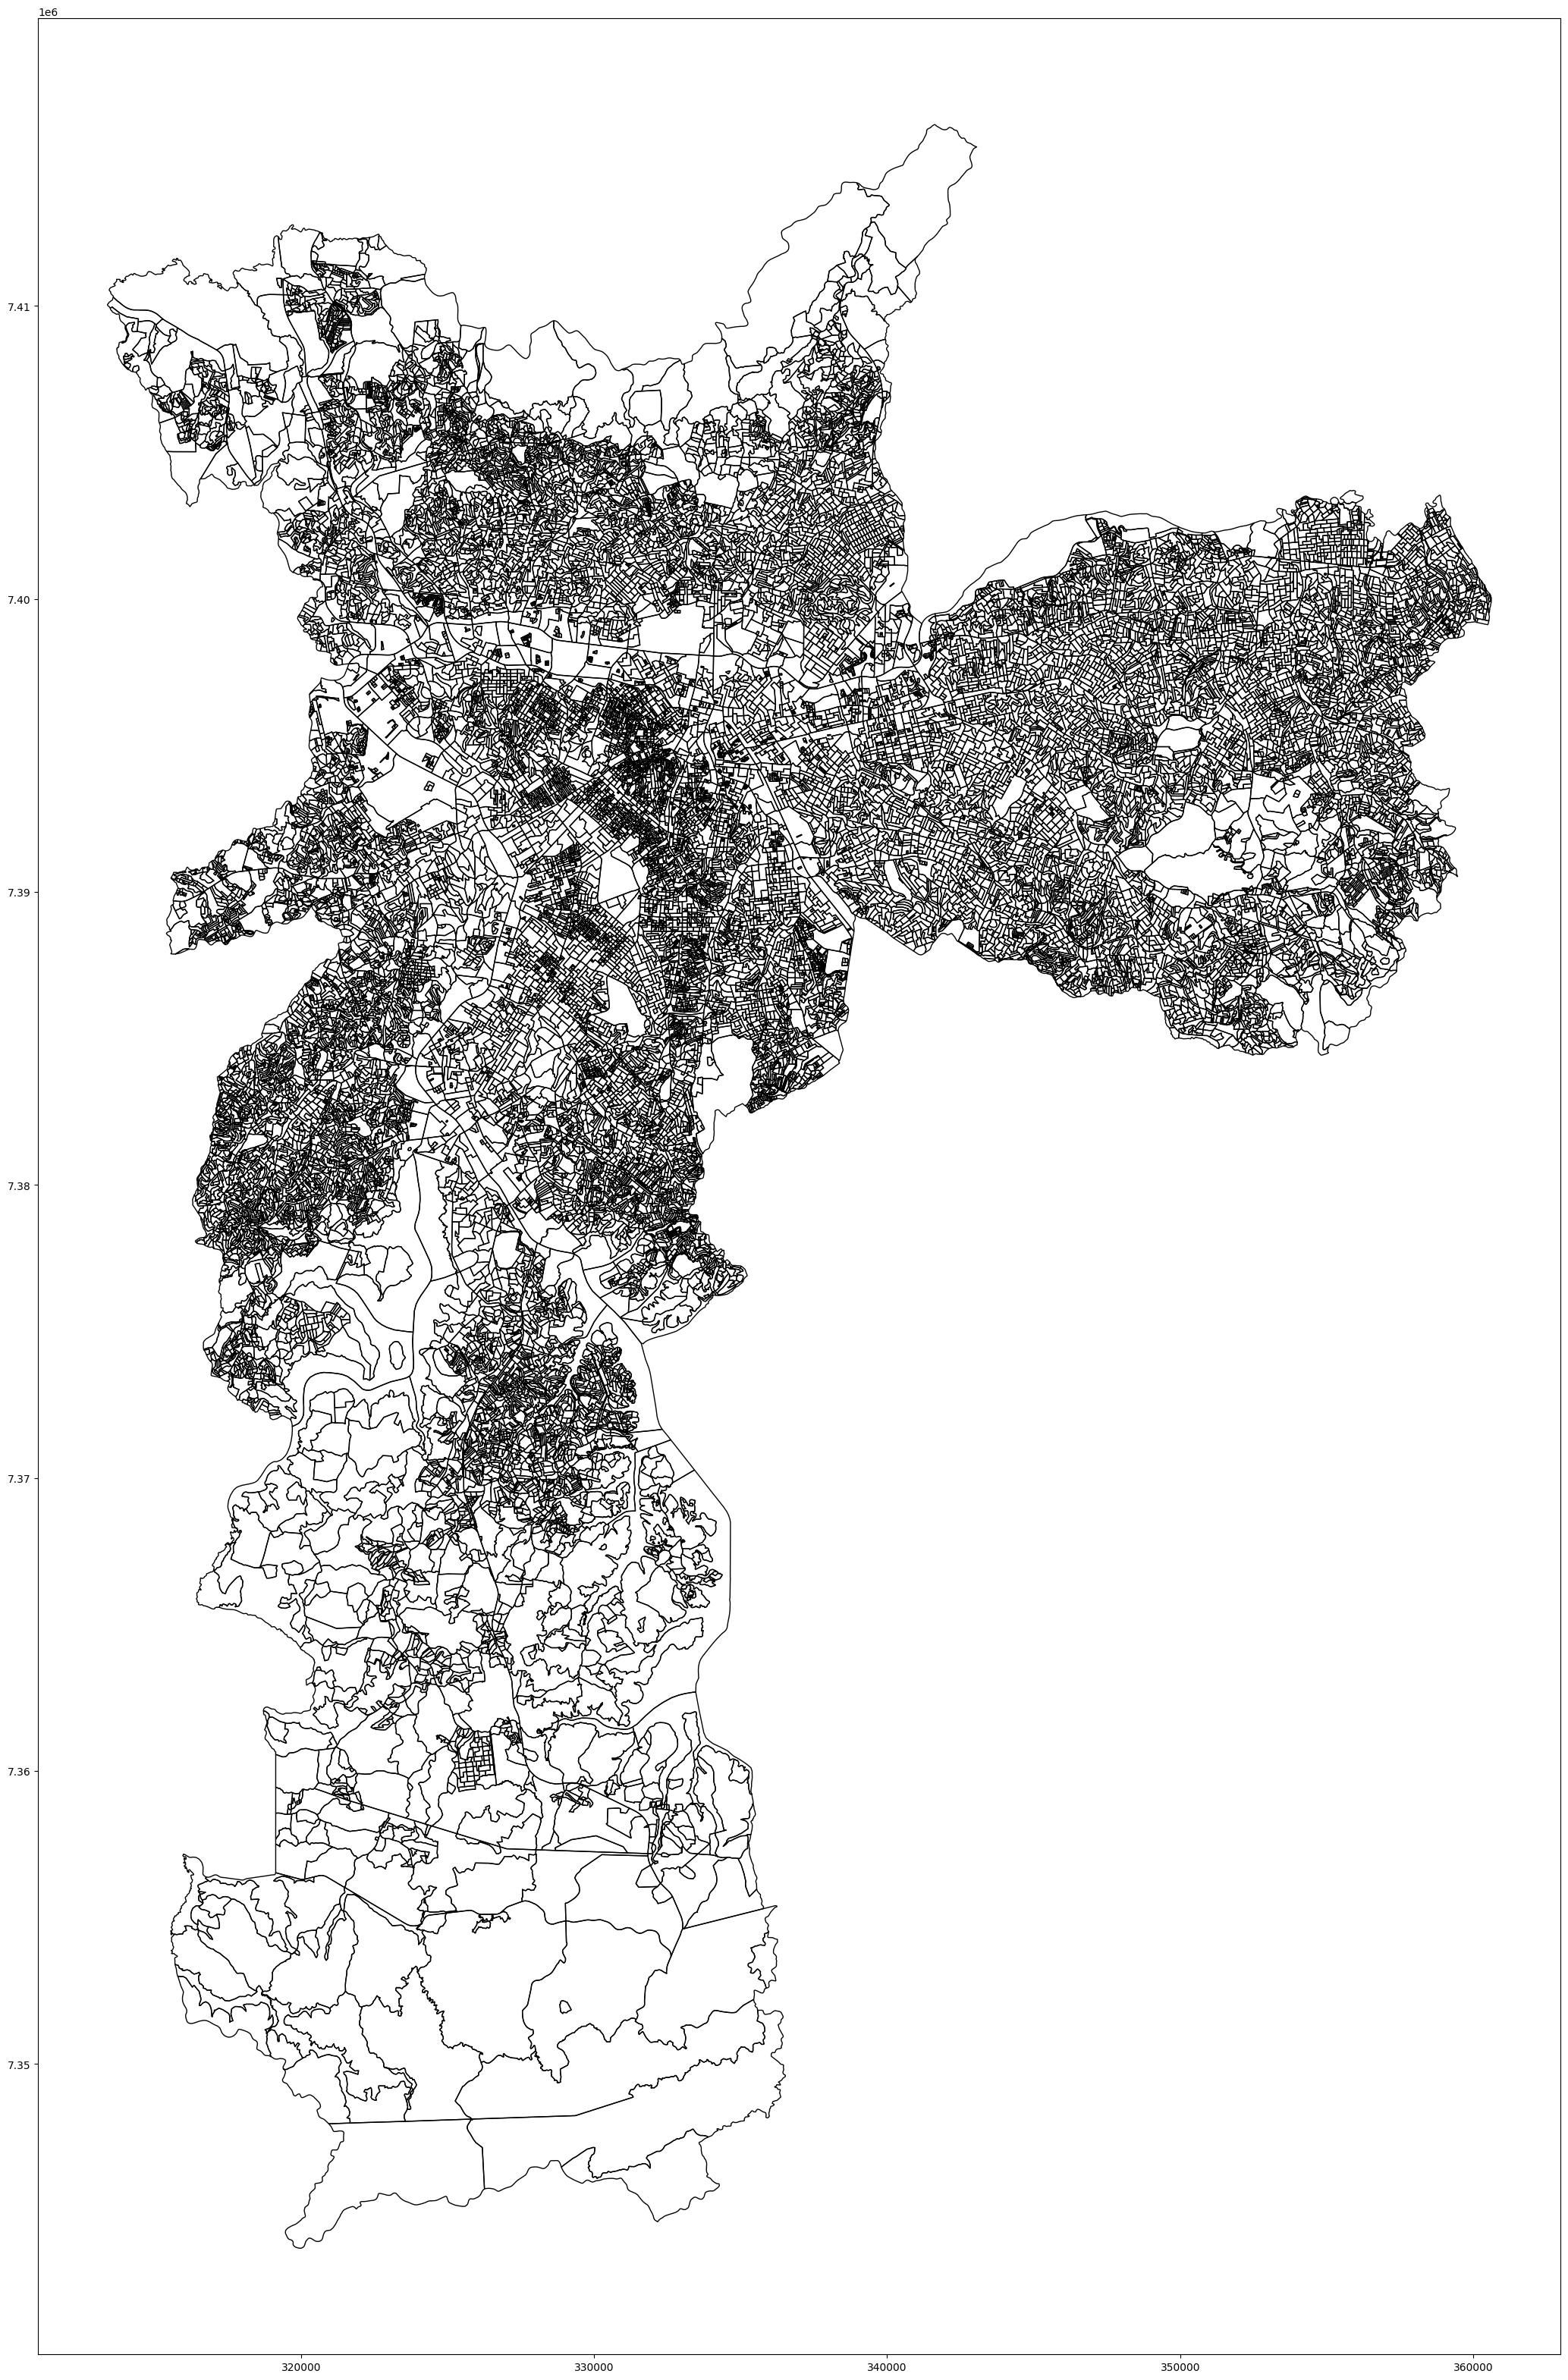

In [ ]:
gdf_dens = gpd.read_file(PATH_DENSITY)
gdf_dens = gdf_dens.to_crs(crs="EPSG:4674")
#gdf_dens.plot()
fig2, ax2 = plt.subplots(figsize=(40, 40))
gdf_dens.plot(ax=ax2, facecolor="None", edgecolor="black", linewidth=1)

In [118]:
gdf_hidro = gpd.read_file(PATH_HIDRO)
#gdf_hidro.set_crs(epsg=4674, inplace=True)
#gdf_hidro = gdf_hidro.to_crs(crs="EPSG:4674")

#gdf_hidro = gdf_hidro.set_crs(epsg=4674)
#gdf_hidro.to_crs(gdf_distr.crs, inplace=True)

#gdf_hidro = gdf_hidro.to_crs(crs="EPSG:4674")

#gdf_hidro.plot()


In [119]:
gdf_hidro = gdf_hidro.set_crs("EPSG:4674").to_crs("EPSG:4674")

#set_crs("EPSG:4326").to_crs("EPSG:3857")

gdf_hidro.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

ValueError: aspect must be finite and positive 

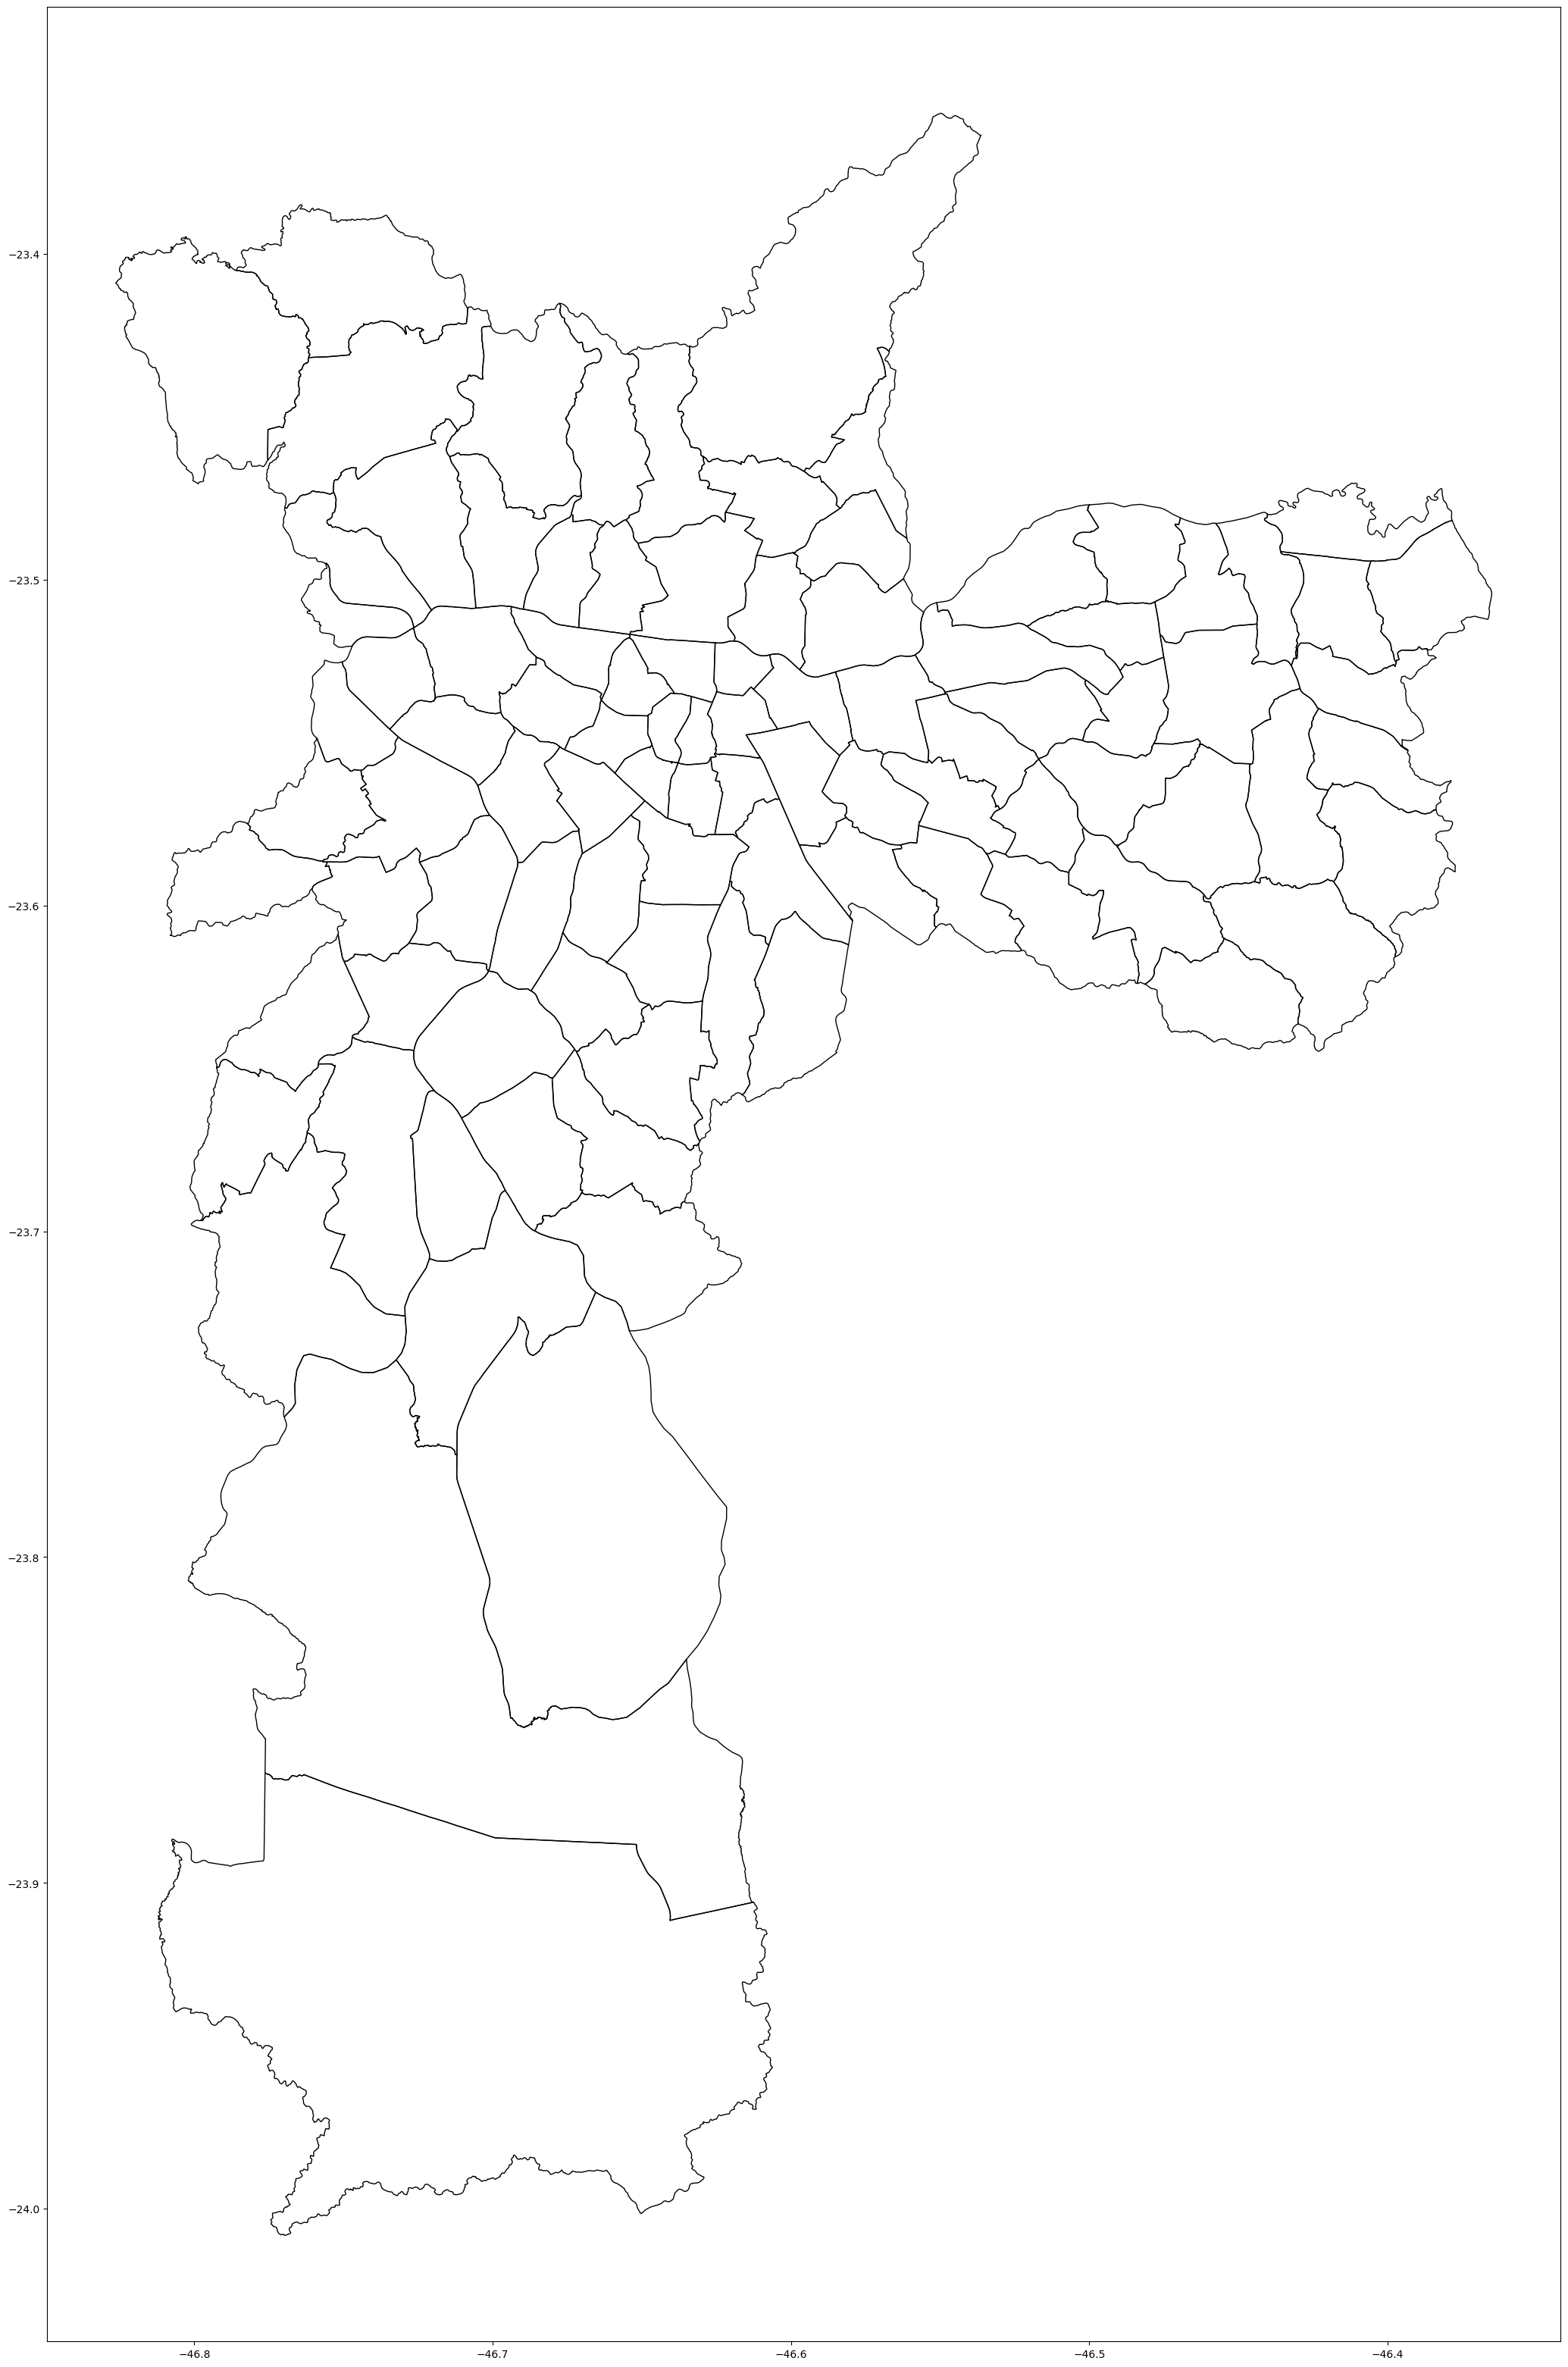

In [120]:
fig, ax = plt.subplots(figsize=(40, 40))
gdf_distr.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=1)
gdf_hidro.plot(ax=ax, facecolor="None", edgecolor="blue", linewidth=2)
sns.scatterplot(data=gdf_loc, x="LONGITUDE", y="LATITUDE", ax=ax, alpha=0.2, size=1, color="red")

In [ ]:
gdf_distr.head()

,ds_codigo,ds_nome,ds_sigla,ds_areakm,ds_areamt,geometry
0,67,RIO PEQUENO,RPE,9.657,9657007.38,"POLYGON ((320567.464 7394377.312, 320581.184 7..."
1,25,CIDADE TIRADENTES,CTI,14.939,14939046.96,"POLYGON ((357428.688 7387653.528, 357433.497 7..."
2,46,JARDIM SAO LUIS,JDS,26.048,26047523.11,"POLYGON ((321618.419 7377778.152, 321559.629 7..."
3,64,PONTE RASA,PRA,6.597,6596680.61,"POLYGON ((344730.886 7398738.087, 344738.505 7..."
4,49,LIBERDADE,LIB,3.651,3651129.57,"POLYGON ((332504.515 7392094.984, 332505.952 7..."


In [59]:
gdf_loc.head()

,PERIDOOCORRENCIA,LATITUDE,LONGITUDE,period,year,month,date,geometry
2,A NOITE,-23.647899,-46.750917,2023_01,2023,1,2023-01-01,POINT (-46.75092 -23.6479)
6,A NOITE,-23.486090,-46.719944,2023_01,2023,1,2023-01-01,POINT (-46.71994 -23.48609)
9,A NOITE,-23.666996,-46.693236,2023_01,2023,1,2023-01-01,POINT (-46.69324 -23.667)
10,A NOITE,-23.642569,-46.767180,2023_01,2023,1,2023-01-01,POINT (-46.76718 -23.64257)
12,A NOITE,-23.584936,-46.501309,2023_01,2023,1,2023-01-01,POINT (-46.50131 -23.58494)
